# World Living Cost Prediction (Part 2)

#### World cities living cost data set
The data set contains information for a number of cities related to cost of living index and prices for a number of services and goods related to restaurants, markets, transportation, utilities etc.

Cost of living index is measured against New York city, meaning NYC has a cost index of 100 and the remaining cities get their cost of living index with regards to how much more or less expensive are compared to NYC. Cities where the cost of living index is not available, it has been registered as 0.

Since EU and USA have different currencies the costs have been converted to euro for all the cities in the data set.

Besides the World Living Cost data, we collected cities information such as the latitude, longitude and population from https://simplemaps.com/data/world-cities.

Data Source: The data has been collected using a python web crawler through the www.numbeo.com website.

In this notebook we explore approaches to predicting Cost of Living by using the [Kaggle world cities living cost](https://www.kaggle.com/georgeliarommatis/world-cities-living-cost?select=cities.csv
) dataset and world cities from https://simplemaps.com/data/world-cities.

### Table of Contents:
### [Import required modules](#cell0)
### [Feature Engineering & Modeling](#cell1)
* [1. Baseline Prediction Models](#cell2)
* [1.1 Read Pre-processed Data](#cell3)
* [1.2 Normalize Data -- log transformation](#cell4)
* [1.3 Simple test to run multiple models against our data.](#cell5)
* [2. Feature Engineering -- Recusive Feature Engineering](#cell6)
  * [2.1 Find Selected Features from RFE](#cell7)
  * [2.2 Using BayesianRidge Model with newly selected features from RFE](#cell8)
  * [2.3 Generate the prediction from Test Set](#cell9)
  * [2.4 Feature Importance with RFE & Bayesian Ridge Model](#cell10)
  * [2.5  The Model Slope & intercept & Coefficient](#cell11)
  * [2.6  Plot Test Value vs. Predict Value](#cell12)
* [3. Feature Engineering -- PCA (Principal Component Analysis)](#cell13)
  * [3.1 Find Compoments from PCA](#cell14)
  * [3.2 Select the best model with newly selected components from PCA](#cell15)
  * [3.3 Generate the prediction from Test Set ---Bayesian Ridge Model with PCA Feather Engineering](#cell16)
  * [3.4 Feature Importance with PCA and BayesianRidge](#cell17)  
  * [3.4 Plot Test Value vs. Predict Value](#cell18)
* [4. Summary](#cell19)

* [Authors](#authors)
  

<a id='cell0'></a>
## Import required modules

In [1]:
import pandas as pd 
import numpy as np   
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
%matplotlib inline
import tensorflow as tf
import seaborn
import warnings
warnings.filterwarnings('ignore')

from subprocess import check_output

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future ve

<a id='cell1'></a>

## Feature Engineering & Modeling

<a id='cell2'></a>

### 1. Baseline Prediction Models

<a id='cell3'></a>
#### 1. 1 Read Pre-processed Data

In [2]:
df = pd.read_csv("city_geo_cost_v4.csv")
df.head()

,City,Cost_index,Rst_MealInexpensiveRestaurant,Rst_Mealfor2People_Mid-rangeRestaurantThree-course,Rst_McMealatMcDonalds,Rst_DomesticBeerhalfliter,Rst_ImportedBeerOneThirdliterbottle,Rst_Cappuccinoregular,Rst_CokePepsiOneThirdliterbottle,Mkt_Milkregular1liter,...,Rent_Apartment3bedroomsinCityCentre,Rent_Apartment3bedroomsOutsideofCentre,BuyHouse_PriceperSquareMetertoBuyApartmentinCityCentre,BuyHouse_PriceperSquareMetertoBuyApartmentOutsideofCentre,Sal_AverageMonthlyNetSalaryAfterTax,lat,lng,country,iso3,population
0,Turin,65.63,15.0,60.0,8.00,4.00,4.00,1.41,1.98,1.10,...,1107.24,765.17,3435.42,1976.00,1413.44,45.0704,7.6700,Italy,ITA,1652000
1,Milan,75.78,15.0,60.0,8.00,5.00,5.00,1.51,2.54,1.23,...,2507.87,1514.29,8549.13,3786.26,1651.84,45.4700,9.2050,Italy,ITA,2945000
2,Chemnitz,0.00,8.5,40.0,7.75,3.00,3.75,3.00,2.08,0.68,...,850.00,675.00,3000.00,1516.67,1962.50,50.8300,12.9200,Germany,DEU,302643
3,Dublin,77.85,15.0,62.5,8.50,5.75,6.00,3.29,1.86,0.97,...,3035.56,2372.22,5587.01,4026.59,2490.81,53.3331,-6.2489,Ireland,IRL,1059000
4,Bonn,66.01,9.5,55.0,7.50,3.50,3.50,2.61,2.06,0.74,...,1507.69,1138.46,7433.33,4933.33,2431.83,50.7205,7.0800,Germany,DEU,680543


In [3]:
feature_cols = ['Rst_MealInexpensiveRestaurant',
 'Rst_Mealfor2People_Mid-rangeRestaurantThree-course',
 'Rst_McMealatMcDonalds',
 'Rst_DomesticBeerhalfliter',
 'Rst_ImportedBeerOneThirdliterbottle',
 'Rst_Cappuccinoregular',
 'Rst_CokePepsiOneThirdliterbottle',
 'Mkt_Milkregular1liter',
 'Mkt_LoafofFreshWhiteBread500g',
 'Mkt_Ricewhite1kg',
 'Mkt_Eggsregular12',
 'Mkt_LocalCheese1kg',
 'Mkt_ChickenFillets1kg',
 'Mkt_BeefRound1kgBackLegRedMeat',
 'Mkt_Apples1kg',
 'Mkt_Banana1kg',
 'Mkt_Oranges1kg',
 'Mkt_Tomato1kg',
 'Mkt_Potato1kg',
 'Mkt_Onion1kg',
 'Mkt_Lettuce1head',
 'Mkt_WaterOneandHalfliterbottle',
 'Mkt_BottleofWineMid-Range',
 'Mkt_DomesticBeerHalfliterbottle',
 'Mkt_ImportedBeerOneThirdliterbottle',
 'Mkt_Cigarettes20PackMarlboro',
 'Trsp_One-wayTicket',
 'Trsp_MonthlyPassTransportation',
 'Trsp_TaxiStart',
 'Trsp_Taxi1km',
 'Trsp_Taxi1hourWaiting',
 'Trsp_Gasoline1liter',
 'Trsp_VolkswagenGolf1490KWTrendline',
 'Trsp_ToyotaCorollaSedan16l97kWComfort',
 'Uty_BasicElectricityHeatingCoolingWaterGarbage',
 'Uty_1minofPrepaidMobileTariffLocal_NoDiscounts',
 'Uty_Internet60MbpsorMoreUnlimitedDataCable',
 'SptEnt_FitnessClubMonthlyFeefor1Adult',
 'SptEnt_TennisCourtRent1HouronWeekend',
 'SptEnt_CinemaInternationalRelease1Seat',
 'ChCare_PreschoolFullDayPrivateMonthlyfor1Child',
 'ChCare_InternationalPrimarySchoolYearlyfor1Child',
 'Cloth_1PairofJeans_Levis501',
 'Cloth_1ummerDressinaChainStore_Zara',
 'Cloth_1PairofNikeRunningShoesMid-Range',
 'Cloth_1PairofMenLeatherBusinessShoes',
 'Rent_Apartment1bedroominCityCentre',
 'Rent_Apartment1bedroomOutsideofCentre',
 'Rent_Apartment3bedroomsinCityCentre',
 'Rent_Apartment3bedroomsOutsideofCentre',
 'BuyHouse_PriceperSquareMetertoBuyApartmentinCityCentre',
 'BuyHouse_PriceperSquareMetertoBuyApartmentOutsideofCentre',
 'Sal_AverageMonthlyNetSalaryAfterTax',
 'population']
costIndex_df = df[df['Cost_index'] !=0]
X = costIndex_df[feature_cols]
y = costIndex_df[['Cost_index']]

<a id='cell4'></a>
#### 1.2 Normalize Data -- log transformation
If the original data follows a log-normal distribution or approximately so, then the log-transformed data follows a normal or near normal distribution. In this case, the log-transformation does remove or reduce skewness.

In [4]:
# Log transformation
X = np.log(X)
y = np.log(y)

# Change -inf to 0 again
X[X==-np.inf]=0
print(X.shape)

(175, 54)


In [5]:
X[0:5]

,Rst_MealInexpensiveRestaurant,Rst_Mealfor2People_Mid-rangeRestaurantThree-course,Rst_McMealatMcDonalds,Rst_DomesticBeerhalfliter,Rst_ImportedBeerOneThirdliterbottle,Rst_Cappuccinoregular,Rst_CokePepsiOneThirdliterbottle,Mkt_Milkregular1liter,Mkt_LoafofFreshWhiteBread500g,Mkt_Ricewhite1kg,...,Cloth_1PairofNikeRunningShoesMid-Range,Cloth_1PairofMenLeatherBusinessShoes,Rent_Apartment1bedroominCityCentre,Rent_Apartment1bedroomOutsideofCentre,Rent_Apartment3bedroomsinCityCentre,Rent_Apartment3bedroomsOutsideofCentre,BuyHouse_PriceperSquareMetertoBuyApartmentinCityCentre,BuyHouse_PriceperSquareMetertoBuyApartmentOutsideofCentre,Sal_AverageMonthlyNetSalaryAfterTax,population
0,2.708050,4.094345,2.079442,1.386294,1.386294,0.343590,0.683097,0.095310,0.444686,0.559616,...,4.336114,4.795046,6.343441,6.040993,7.009626,6.640098,8.141894,7.588830,7.253782,14.317497
1,2.708050,4.094345,2.079442,1.609438,1.609438,0.412110,0.932164,0.207014,0.698135,0.879627,...,4.510750,4.930798,7.062192,6.617510,7.827189,7.322702,9.053585,8.239134,7.409645,14.895619
3,2.708050,4.135167,2.140066,1.749200,1.791759,1.190888,0.620576,-0.030459,0.378436,0.488580,...,4.422449,4.578621,7.444161,7.268774,8.018151,7.771582,8.628200,8.300675,7.820363,13.872836
4,2.251292,4.007333,2.014903,1.252763,1.252763,0.959350,0.722706,-0.301105,0.139762,0.815365,...,4.288814,4.609461,6.665200,6.373576,7.318334,7.037432,8.913729,8.503769,7.796399,13.430646
5,2.708050,3.912023,2.079442,1.609438,1.609438,0.438255,0.943906,0.157004,0.774727,0.741937,...,4.540632,4.553877,6.417549,6.214608,6.940542,6.663554,7.989560,7.335197,7.286952,12.075406


In [6]:
y[0:5]

,Cost_index
0,4.184033
1,4.327834
3,4.354784
4,4.189806
5,4.242621


<a id='cell5'></a>
#### 1.3 Simple test to run multiple models against our data. 
First, with raw features. No any feature selection applied.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 0)

#### R-squared evaluates the scatter of the data points around the fitted regression line. It is also called the coefficient of determination, or the coefficient of multiple determination for multiple regression. For the same data set, higher R-squared values represent smaller differences between the observed data and the fitted values.

In [8]:
# R2 Score
# 10-fold cross validation is for randomization.

def lets_try(train,labels):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=10,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)
    
    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    
    clf = svm.SVR()
    results["SVM RBF"]=test_model(clf)
    
    clf = svm.SVR(kernel="linear")
    results["SVM Linear"]=test_model(clf)
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"] 
    results=results.sort_values('R Square Score', ascending=False)
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return results

,R Square Score
Bayesian Ridge,0.840123
Ridge,0.837956
Lasso,0.815228
AdaBoost,0.799504
Linear,0.788093
SVM RBF,0.772027
Hubber,0.768120
RandomForest,0.754570
SVM Linear,0.745302
Bagging,0.722309


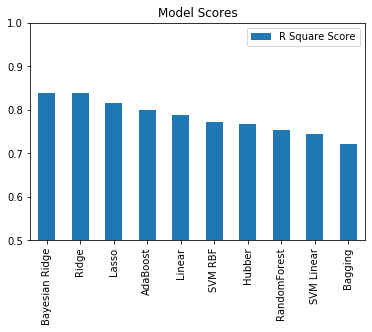

In [9]:
lets_try(X_train,y_train)

<a id='cell6'></a>

### 2. Feature Engineering -- RFE (Recusive Feature Elimination)

#### from the models above, we will apply RFE to the best model -- BayesianRidge

In [41]:
#no of features
nof_list=np.arange(1,54)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import RFE

for n in range(len(nof_list)):
    model = BayesianRidge()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features for BayesianRidge Model: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features for BayesianRidge Model: 53
Score with 53 features: 0.741204


<span style="color: red;">The features are reduced from 54 to 19 after RFE with BayesianRidge Model.</span>

#### from the models above, we will apply RFE to the lower performance model -- HuberRegressor

In [11]:
#no of features
nof_list=np.arange(1,54)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor
from sklearn.feature_selection import RFE

for n in range(len(nof_list)):
    model = HuberRegressor()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features for HuberRegressor Model: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features for HuberRegressor Model: 4
Score with 4 features: 0.777877


<span style="color: red;">The features are reduced from 54 to 4 after **RFE** with HuberRegressor Model.</span>
<span style="color: blue;">This is the interesting finding. If the R2 around 0.78 is acceptable, the execution time of training and prediction will be dramatically improved with **HuberRegression Model** in large dataset.</span>
<span style="color: blue;">Because the features are reduced from 54 to 4.This can be a very good candidate also.</span>

<a id='cell7'></a>
#### 2.1 Find Selected Features from RFE

In [12]:
cols = feature_cols
model = BayesianRidge()
#Initializing RFE model
rfe = RFE(model, 19)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Rst_MealInexpensiveRestaurant',
       'Rst_Mealfor2People_Mid-rangeRestaurantThree-course',
       'Rst_McMealatMcDonalds', 'Rst_DomesticBeerhalfliter',
       'Rst_Cappuccinoregular', 'Mkt_Milkregular1liter', 'Mkt_Eggsregular12',
       'Mkt_LocalCheese1kg', 'Mkt_ChickenFillets1kg',
       'Mkt_BeefRound1kgBackLegRedMeat', 'Mkt_Apples1kg', 'Mkt_Oranges1kg',
       'Mkt_Tomato1kg', 'Trsp_One-wayTicket', 'Trsp_Gasoline1liter',
       'Uty_BasicElectricityHeatingCoolingWaterGarbage',
       'Cloth_1PairofNikeRunningShoesMid-Range',
       'Rent_Apartment1bedroominCityCentre',
       'Rent_Apartment3bedroomsOutsideofCentre'],
      dtype='object')


<a id='cell8'></a>
#### 2.2 Select the best model with newly selected features from RFE

In [13]:
selected_feature_cols = ['Rst_MealInexpensiveRestaurant',
       'Rst_Mealfor2People_Mid-rangeRestaurantThree-course',
       'Rst_McMealatMcDonalds', 'Rst_DomesticBeerhalfliter',
       'Rst_Cappuccinoregular', 'Mkt_Milkregular1liter', 'Mkt_Eggsregular12',
       'Mkt_LocalCheese1kg', 'Mkt_ChickenFillets1kg',
       'Mkt_BeefRound1kgBackLegRedMeat', 'Mkt_Apples1kg', 'Mkt_Oranges1kg',
       'Mkt_Tomato1kg', 'Trsp_One-wayTicket', 'Trsp_Gasoline1liter',
       'Uty_BasicElectricityHeatingCoolingWaterGarbage',
       'Cloth_1PairofNikeRunningShoesMid-Range',
       'Rent_Apartment1bedroominCityCentre',
       'Rent_Apartment3bedroomsOutsideofCentre']
X_RFE_train = X_train[selected_feature_cols]
X_RFE_test = X_test[selected_feature_cols]#.values
y_RFE_train = y_train['Cost_index']
y_RFE_test = y_test['Cost_index'] 
print ('Train set:', X_RFE_train.shape,  y_RFE_train.shape)
print ('Test set:', X_RFE_test.shape,  y_RFE_test.shape)
X_RFE_train[0:5]

Train set: (131, 19) (131,)
Test set: (44, 19) (44,)


,Rst_MealInexpensiveRestaurant,Rst_Mealfor2People_Mid-rangeRestaurantThree-course,Rst_McMealatMcDonalds,Rst_DomesticBeerhalfliter,Rst_Cappuccinoregular,Mkt_Milkregular1liter,Mkt_Eggsregular12,Mkt_LocalCheese1kg,Mkt_ChickenFillets1kg,Mkt_BeefRound1kgBackLegRedMeat,Mkt_Apples1kg,Mkt_Oranges1kg,Mkt_Tomato1kg,Trsp_One-wayTicket,Trsp_Gasoline1liter,Uty_BasicElectricityHeatingCoolingWaterGarbage,Cloth_1PairofNikeRunningShoesMid-Range,Rent_Apartment1bedroominCityCentre,Rent_Apartment3bedroomsOutsideofCentre
192,2.613740,4.000034,1.985131,1.654411,1.353255,-0.356675,0.262364,2.280339,1.859418,2.305581,1.504077,1.611436,1.108563,0.463734,-0.579818,4.891326,4.186924,6.948148,7.177561
20,2.708050,3.960813,2.169054,1.931521,1.223775,0.039221,1.007958,2.564949,2.590017,2.708050,1.098612,1.153732,1.098612,0.405465,0.425268,4.821007,4.398884,6.678040,7.228229
160,2.613740,4.000034,1.953028,1.515127,1.235471,0.000000,0.896088,2.288486,2.142416,2.399712,1.724551,1.088562,1.470176,0.824175,-0.400478,4.940642,4.260283,7.311085,7.396262
80,2.079442,3.784190,1.945910,1.252763,0.978326,-0.356675,0.641854,2.113843,2.018895,2.327278,0.837248,0.672944,0.841567,0.993252,0.371564,5.395399,4.395436,6.250998,6.670475
179,2.576422,3.875774,1.985131,1.291984,1.205971,-0.127833,0.824175,2.389680,2.492379,2.622492,1.749200,1.308333,1.795087,0.598837,-0.510826,4.973833,4.186164,7.174173,7.317943


In [14]:
y_RFE_train[0:5]

192    4.222738
20     4.331917
160    4.369195
80     4.111529
179    4.317488
Name: Cost_index, dtype: float64

,R Square Score
Bayesian Ridge,0.878219
Ridge,0.877404
Lasso,0.873687
Linear,0.871888
Bagging,0.823484
SVM Linear,0.810774
AdaBoost,0.808953
RandomForest,0.801446
SVM RBF,0.798462
Hubber,0.756099


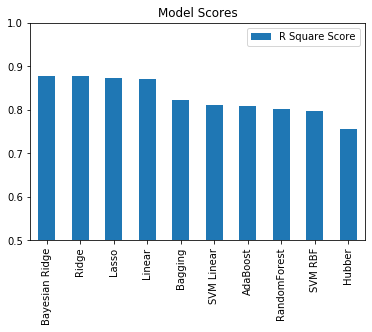

In [15]:
lets_try(X_RFE_train,y_RFE_train)

| R2: Non-RFE(54 features)   |R2: RFE(19 features)     |
| ---------------------- | ------------------- |
| 0.840123              | 0.878219           |


<span style="color: red;"> **Conclusion:** If we reduce the features from 54 to 19 with Bayesian Ridge Model, the performance of the prediction has slightly improved due to removing the noise from some features.

<a id='cell9'></a>
#### 2. 3 Generate the prediction from Test Set -- with RFE & Bayesian Ridge Model

In [17]:
cv = KFold(n_splits=10,shuffle=True,random_state=45)

parameters = {'alpha_1': [1000,100,10],
              'alpha_2' : [1000,100,10],
              'tol' : [1e-10]}

clf = linear_model.BayesianRidge()
r2 = make_scorer(r2_score)
grid_obj = GridSearchCV(clf, parameters, cv=cv,scoring=r2)
grid_fit = grid_obj.fit(X_RFE_train,y_RFE_train)
best_clf = grid_fit.best_estimator_ 

best_clf.fit(X_RFE_train,y_RFE_train)

BayesianRidge(alpha_1=1000, alpha_2=10, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=1e-10, verbose=False)

<a id='cell10'></a>
#### 2. 4 Feature Importance with RFE & Bayesian Ridge Model

Feature: 0, Score: 0.09395
Feature: 1, Score: 0.04349
Feature: 2, Score: 0.00053
Feature: 3, Score: 0.07252
Feature: 4, Score: -0.02420
Feature: 5, Score: -0.02251
Feature: 6, Score: 0.05450
Feature: 7, Score: 0.05024
Feature: 8, Score: 0.04493
Feature: 9, Score: 0.05115
Feature: 10, Score: 0.06393
Feature: 11, Score: 0.03056
Feature: 12, Score: 0.05466
Feature: 13, Score: 0.04265
Feature: 14, Score: -0.02824
Feature: 15, Score: 0.02969
Feature: 16, Score: -0.03479
Feature: 17, Score: -0.01340
Feature: 18, Score: 0.05620


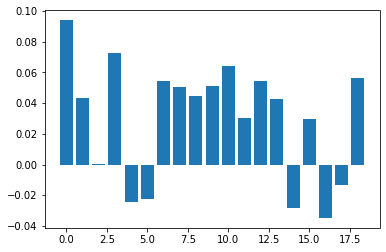

In [40]:
from matplotlib import pyplot
best_clf.fit(X_RFE_train,y_RFE_train)
#model.fit(X, y)
# get importance
importance = best_clf.coef_
# summarize feature importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

<span style="color: red;">Conclusion: The 1st component from RFE contributes the most positive impact on the prediction, and 17th component from RFE contributes the most negative impact on the prediction.</span>

#### The slope and intercept of the data are contained in the model's fit parameters. The value of 𝑏₀, also called the intercept, shows the point where the estimated regression line crosses the 𝑦 axis. It is the value of the estimated response 𝑓(𝑥) for 𝑥 = 0. The value of 𝑏₁ determines the slope of the estimated regression line.

##### In regression with multiple independent variables, the coefficient tells you how much the dependent variable is expected to increase when that independent variable increases by one, holding all the other independent variables constant. Remember to keep in mind the units which your variables are measured in.

<a id='cell11'></a>
#### 2. 5 The Model Slope & intercept & Coefficient

In [19]:
print("model intercept:", best_clf.intercept_)
print("model slope:    ", best_clf.coef_[0])
print(best_clf.coef_)
zip(X_RFE_train, best_clf.coef_)
# pair the feature names with the coefficients
list(zip(selected_feature_cols, best_clf.coef_))

model intercept: 2.8745809076529674
model slope:     0.09395069574431836
[ 0.0939507   0.04348782  0.00052603  0.07251595 -0.02420436 -0.02250672
  0.05450454  0.05023798  0.04493367  0.051155    0.06392574  0.03056158
  0.05466008  0.04265172 -0.02824066  0.02968589 -0.03478688 -0.01340486
  0.05619769]


[('Rst_MealInexpensiveRestaurant', 0.09395069574431836),
 ('Rst_Mealfor2People_Mid-rangeRestaurantThree-course', 0.04348781916588246),
 ('Rst_McMealatMcDonalds', 0.0005260269756953151),
 ('Rst_DomesticBeerhalfliter', 0.07251595036428171),
 ('Rst_Cappuccinoregular', -0.024204358171406815),
 ('Mkt_Milkregular1liter', -0.022506720431722277),
 ('Mkt_Eggsregular12', 0.054504540731278),
 ('Mkt_LocalCheese1kg', 0.050237982713493695),
 ('Mkt_ChickenFillets1kg', 0.044933671066975545),
 ('Mkt_BeefRound1kgBackLegRedMeat', 0.05115499644457219),
 ('Mkt_Apples1kg', 0.06392573613348868),
 ('Mkt_Oranges1kg', 0.030561582687508748),
 ('Mkt_Tomato1kg', 0.05466007594987188),
 ('Trsp_One-wayTicket', 0.042651717637412774),
 ('Trsp_Gasoline1liter', -0.028240661170617562),
 ('Uty_BasicElectricityHeatingCoolingWaterGarbage', 0.029685888520712272),
 ('Cloth_1PairofNikeRunningShoesMid-Range', -0.03478688097855144),
 ('Rent_Apartment1bedroominCityCentre', -0.013404858628604188),
 ('Rent_Apartment3bedroomsOutsideo

In [20]:
zipped = list(zip(selected_feature_cols, best_clf.coef_))
sorted(zipped, key = lambda t: t[1], reverse=True)

[('Rst_MealInexpensiveRestaurant', 0.09395069574431836),
 ('Rst_DomesticBeerhalfliter', 0.07251595036428171),
 ('Mkt_Apples1kg', 0.06392573613348868),
 ('Rent_Apartment3bedroomsOutsideofCentre', 0.056197688555068126),
 ('Mkt_Tomato1kg', 0.05466007594987188),
 ('Mkt_Eggsregular12', 0.054504540731278),
 ('Mkt_BeefRound1kgBackLegRedMeat', 0.05115499644457219),
 ('Mkt_LocalCheese1kg', 0.050237982713493695),
 ('Mkt_ChickenFillets1kg', 0.044933671066975545),
 ('Rst_Mealfor2People_Mid-rangeRestaurantThree-course', 0.04348781916588246),
 ('Trsp_One-wayTicket', 0.042651717637412774),
 ('Mkt_Oranges1kg', 0.030561582687508748),
 ('Uty_BasicElectricityHeatingCoolingWaterGarbage', 0.029685888520712272),
 ('Rst_McMealatMcDonalds', 0.0005260269756953151),
 ('Rent_Apartment1bedroominCityCentre', -0.013404858628604188),
 ('Mkt_Milkregular1liter', -0.022506720431722277),
 ('Rst_Cappuccinoregular', -0.024204358171406815),
 ('Trsp_Gasoline1liter', -0.028240661170617562),
 ('Cloth_1PairofNikeRunningShoesMi

The coefficient indicates that for every additional EURO in Rst_MealInexpensiveRestaurant you can expect cost index to increase by an average of 0.09395069574431836.

In [21]:
y_prediction_RFE = best_clf.predict(X_RFE_test)
y_prediction_RFE = np.exp(y_prediction_RFE)
y_RFE_test = np.exp(y_RFE_test)
sub = pd.DataFrame({
        "Cost_Of_living": y_prediction_RFE
    })
sub.to_csv("cost_of_living_test_RFE_BayesianRidge_prediciton.csv", index=False)

In [22]:
y_prediction_RFE[0:5]

array([55.99809343, 79.86754375, 69.62674313, 69.92765782, 85.17431642])

<a id='cell12'></a>
#### 2. 6  Plot Test Value vs. Predict Value

Text(0, 0.5, 'Predict Value')

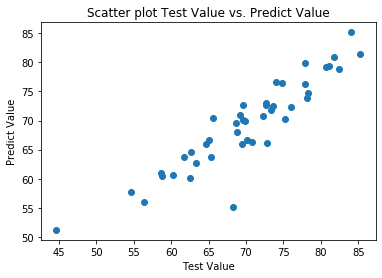

In [23]:
plt.scatter(y_RFE_test, y_prediction_RFE)
plt.title('Scatter plot Test Value vs. Predict Value')
plt.xlabel('Test Value')
plt.ylabel('Predict Value')

###### Regression Performance
The variation of actual responses 𝑦ᵢ, 𝑖 = 1, …, 𝑛, occurs partly due to the dependence on the predictors 𝐱ᵢ. However, there is also an additional inherent variance of the output.

The coefficient of determination, denoted as 𝑅², tells you which amount of variation in 𝑦 can be explained by the dependence on 𝐱 using the particular regression model. Larger 𝑅² indicates a better fit and means that the model can better explain the variation of the output with different inputs.

The value 𝑅² = 1 corresponds to SSR = 0, that is to the perfect fit since the values of predicted and actual responses fit completely to each other.

In [24]:
from sklearn import metrics
import seaborn as sn

print("\nTest Set Regression Metrics:")
print("-----")
print("regression R2 score:{}".format(metrics.r2_score(y_RFE_test, y_prediction_RFE))) #R^2 (coefficient of determination) regression score function.
print("regression MAE :{}".format(metrics.mean_absolute_error(y_RFE_test, y_prediction_RFE))) #Mean absolute error regression loss
print("regression MSE score:{}".format(metrics.mean_squared_error(y_RFE_test, y_prediction_RFE))) #Mean squared error regression loss
print("regression RMSE score:{}".format(np.sqrt(metrics.mean_squared_error(y_RFE_test, y_prediction_RFE)))) #Root mean squared error


Test Set Regression Metrics:
-----
regression R2 score:0.83755002739749
regression MAE :2.5172368677132795
regression MSE score:11.504269879646616
regression RMSE score:3.391794492543234


| R2: RFE Training Set  |R2: RFE Test Set     |
| ---------------------- | ------------------- |
|0.878219            | 0.8375500          |

<span style="color: red;"> **Conclusion: R Square is a good measure to determine how well the model fits the dependent variables. The performance of model fits the dependent variable is slightly declined from 0.878219 to 0.8375500 after reducing the feature from 54 to 19. However it is still in the very acceptable margin.**

<a id='cell13'></a>

### 3. Feature Engineering -- PCA (Principal Component Analysis)

<a id='cell14'></a>
#### 3.1 Find Components from PCA

##### The explained variance tells us how much information (variance) can be attributed to each of the principal components.
#### The idea is to start with n_components = number of columns. Then select the number of components that ideally add up to 1 variance_ratio. However, you can select the number of components to any level which may provide the efficient information.

[0.354  0.5662 0.624  0.6626 0.6959 0.7272 0.7499 0.7719 0.7913 0.8088
 0.824  0.838  0.8518 0.8646 0.8768 0.8867 0.895  0.903  0.9109 0.9184
 0.9255 0.9318 0.9377 0.9433 0.9482 0.9529 0.9574 0.9616 0.965  0.9683
 0.9715 0.9744 0.9771 0.9794 0.9816 0.9836 0.9854 0.9871 0.9887 0.9902
 0.9916 0.9928 0.9939 0.995  0.996  0.9968 0.9975 0.9981 0.9986 0.999
 0.9993 0.9996 0.9998 0.9999]


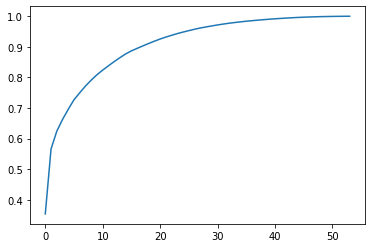

In [25]:
#Scaling the values
X_train = scale(X_train)
pca = PCA(n_components=54)
pca.fit(X_train)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))
print(var1)
plt.plot(var1)

<span style="color: red;">In our case, there is no Dimensionality Reduction from PCA if we  select the number of components that ideally add up to 1 variance_ratio. However, we still like to experiment how the number of components impact on the prediction.</span>

<a id='cell15'></a>
#### 3.2  Select the best model with newly selected components  from PCA

In [26]:
#Looking at above plot I'm taking 43 variables (get 99.39% information from original dataset)
pca = PCA(n_components=43)
pca.fit(X_train)
X_PCA_train=pca.fit_transform(X_train)

print(X_PCA_train)

[[-2.45230473  4.23863971  0.0221076  ...  0.17017641  0.3933856
   0.16290608]
 [-2.56605075 -3.76554545  1.33876525 ...  0.30091165  0.10139483
  -0.14315602]
 [-5.37570949  2.67586342 -0.86126173 ... -0.15505734  0.06571372
  -0.32258199]
 ...
 [-0.45840961  4.95171184  1.35466182 ... -0.40963314  0.05043329
  -0.22596525]
 [-0.75179413 -3.50553034  0.77561164 ...  0.03424887  0.02209116
   0.34346848]
 [-3.71002913  1.55273915 -0.93080928 ...  0.37144446  0.24163827
   0.31031436]]


In [27]:
y_PCA_train = y_train

,R Square Score
Bayesian Ridge,0.835423
Hubber,0.801208
Ridge,0.792972
Lasso,0.788083
Linear,0.780751
Bagging,0.776122
SVM Linear,0.764308
RandomForest,0.751747
AdaBoost,0.749331
SVM RBF,0.678129


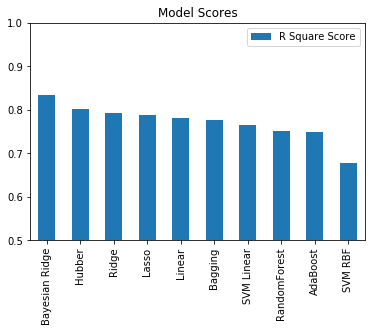

In [28]:
lets_try(X_PCA_train,y_PCA_train)

| R2: Non-PCA(54 features)   |R2: PCA(43 features)     |
| ---------------------- | ------------------- |
| 0.840123              | 0.835423    |

<span style="color: red;"> **Conclusion:** If we reduce the features from 54 to 43 with Bayesian Ridge Model by using PCA, the performance of the prediction is not sacrificed.

<a id='cell16'></a>
#### 3.3 Generate the prediction from Test Set ---Bayesian Ridge Model with PCA Feather Engineering

In [29]:
cv = KFold(n_splits=10,shuffle=True,random_state=45)

parameters = {'alpha_1': [1000,100,10],
              'alpha_2' : [1000,100,10],
              'tol' : [1e-10]}

clf = linear_model.BayesianRidge()
r2 = make_scorer(r2_score)
grid_obj = GridSearchCV(clf, parameters, cv=cv,scoring=r2)
grid_fit = grid_obj.fit(X_PCA_train,y_PCA_train)
best_clf = grid_fit.best_estimator_ 

best_clf.fit(X_PCA_train,y_PCA_train)

BayesianRidge(alpha_1=1000, alpha_2=10, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=1e-10, verbose=False)

In [30]:
X_test.shape

(44, 54)

In [31]:
X_test = scale(X_test)
pca = PCA(n_components=43)
pca.fit(X_test)
X_PCA_test=pca.fit_transform(X_test)
print(X_PCA_test)
y_PCA_test = y_test

y_prediction_PCA = best_clf.predict(X_PCA_test)
y_prediction_PCA = np.exp(y_prediction_PCA)
y_PCA_test = np.exp(y_PCA_test)
sub = pd.DataFrame({
        "Cost_Of_living": y_prediction_PCA
    })
sub.to_csv("cost_of_living_test_PCA_BayesianRidge_prediciton.csv", index=False)

[[-3.97578700e+00  5.40686246e+00  3.92823917e+00 ... -1.87107960e-02
   7.33327191e-02 -2.18688500e-02]
 [ 5.21703545e+00 -3.19042709e+00 -1.46322284e+00 ...  8.76489083e-02
   3.84745215e-03 -3.64541645e-02]
 [-2.97441275e+00 -7.54048096e-01  3.00296503e+00 ... -2.17144626e-01
   1.06256871e-01 -5.39555557e-02]
 ...
 [-7.17488543e-01 -2.98248392e+00  1.98206805e+00 ...  5.16103174e-02
   1.88125921e-02  1.25273384e-02]
 [-1.56788995e+00 -6.94613284e+00  6.40568096e-01 ...  6.35331007e-02
   3.50384275e-03 -5.00233614e-02]
 [ 5.13669411e+00 -2.87773663e+00 -1.07967525e+00 ... -2.22763816e-01
  -1.77882470e-01  1.86075465e-02]]


In [32]:
y_prediction_PCA[0:5]

array([72.98611551, 59.42678891, 77.93524308, 79.37642564, 59.59710968])

##### All of these algorithms find a set of coefficients to use in the weighted sum in order to make a prediction. These coefficients can be used directly as a crude type of feature importance score.

<a id='cell17'></a>
#### 3.4  Feature Importance with PCA and BayesianRidge

Feature: 0, Score: -0.03279
Feature: 1, Score: -0.00573
Feature: 2, Score: 0.00275
Feature: 3, Score: -0.00438
Feature: 4, Score: -0.01452
Feature: 5, Score: -0.01093
Feature: 6, Score: 0.00056
Feature: 7, Score: -0.01098
Feature: 8, Score: 0.00203
Feature: 9, Score: -0.00269
Feature: 10, Score: 0.01086
Feature: 11, Score: -0.00419
Feature: 12, Score: 0.00710
Feature: 13, Score: 0.00661
Feature: 14, Score: 0.00370
Feature: 15, Score: 0.00165
Feature: 16, Score: -0.00466
Feature: 17, Score: -0.00975
Feature: 18, Score: 0.00907
Feature: 19, Score: -0.00431
Feature: 20, Score: 0.00189
Feature: 21, Score: 0.00504
Feature: 22, Score: 0.00605
Feature: 23, Score: 0.00376
Feature: 24, Score: 0.00050
Feature: 25, Score: -0.00636
Feature: 26, Score: -0.00114
Feature: 27, Score: -0.00095
Feature: 28, Score: -0.00063
Feature: 29, Score: 0.00162
Feature: 30, Score: 0.00281
Feature: 31, Score: -0.00115
Feature: 32, Score: -0.00341
Feature: 33, Score: -0.00089
Feature: 34, Score: 0.00169
Feature: 35,

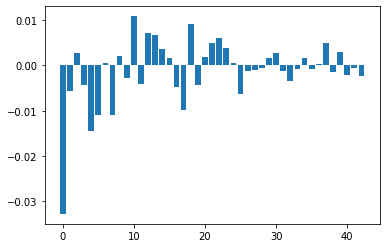

In [33]:
from matplotlib import pyplot
best_clf.fit(X_PCA_train,y_PCA_train)
#model.fit(X, y)
# get importance
importance = best_clf.coef_
# summarize feature importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()



<span style="color: red;"> **Conclusion:** The 1st component from PCA contributes the most negative impact on the prediction, and 11th component from PCA contributes the most positive impact on the prediction.</span>

<a id='cell18'></a>
#### 3. 5  Plot Test Value vs. Predict Value

Text(0, 0.5, 'Predict Value')

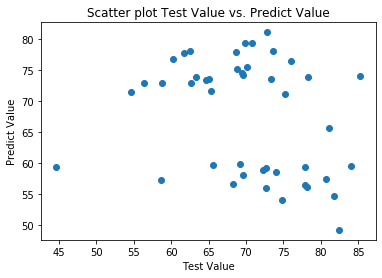

In [34]:
plt.scatter(y_PCA_test, y_prediction_PCA)
plt.title('Scatter plot Test Value vs. Predict Value')
plt.xlabel('Test Value')
plt.ylabel('Predict Value')

In [35]:
from sklearn import metrics
import seaborn as sn

print("\nTest Set Regression Metrics:")
print("-----")
print("regression R2 score:{}".format(metrics.r2_score(y_RFE_test, y_prediction_RFE))) #R^2 (coefficient of determination) regression score function.
print("regression MAE :{}".format(metrics.mean_absolute_error(y_RFE_test, y_prediction_RFE))) #Mean absolute error regression loss
print("regression MSE score:{}".format(metrics.mean_squared_error(y_RFE_test, y_prediction_RFE))) #Mean squared error regression loss
print("regression RMSE score:{}".format(np.sqrt(metrics.mean_squared_error(y_RFE_test, y_prediction_RFE)))) #Root mean squared error


Test Set Regression Metrics:
-----
regression R2 score:0.83755002739749
regression MAE :2.5172368677132795
regression MSE score:11.504269879646616
regression RMSE score:3.391794492543234


| R2: PCA Training Set  |R2: PCA Test Set     |
| ---------------------- | ------------------- |
|0.835423            |0.8375500          |

| R2: RFE Training Set  |R2: RFE Test Set     | R2: PCA Training Set  |R2: PCA Test Set     |
| ---------------------- | ------------------- | ---------------------- | ------------------- |
|0.878219             | 0.8375500          |0.835423            |0.8375500          |

<span style="color: red;"> **Conclusion:** Even PCA BayesianRidge Test Set R2 is clost to RFE BayesianRidge Model  Test Set R2. From the plot, RFE BayesianRidge Model demstrates the consistent prediction pattern, which is a more stable prediction then PCA BayesianRidge Model.In this case, we don’t see any lift in model performance in using the PCA transform.</span>

<a id='cell19'></a>
### 4. Summary

In this project, we performed the **baseline model selection** from **Bayesian Ridge, Ridge, Lasso, Linear, SVM Linear, AdaBoost, RandomForest, SVM RBF, Bagging, and Hubber** based on **R Square Score**. The best baseline model is **Bayesian Ridge**. 

After that we applied **RFE** and **PCA** techniques to identify the best features for the training and generate the optimized prediction. We compared prediction result based on the Regression Metrics (R2, MAE, MSE, and RMSE) as well as the plot of Test Value vs. Predict Value. 

Although PCA BayesianRidge Test Set R2 is clost to RFE BayesianRidge Model Test Set R2, RFE BayesianRidge Model demstrates the consistent prediction pattern also the feature is reduced from 54 to 19 while comparing PCS BayesianRidge Model with 43 features. 

In this project, we believe **BayesianRidge(alpha_1=1000, alpha_2=10, compute_score=False, copy_X=True,fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,normalize=False, tol=1e-10, verbose=False)** with **R2 = 0.83755** will reach the highly consistent and accurate prediction.

<a id='authors'></a>
#### Authors
Selina Nie